# Electric Power Consumption

https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by 9 feature columns.

    Date Time: Time window of ten minutes.
    
    Temperature: Weather Temperature.
    
    Humidity: Weather Humidity.
    
    Wind Speed: Wind Speed.
    
    General Diffuse Flows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
    
    Diffuse Flows
    
    Zone 1 Power Consumption
    
    Zone 2 Power Consumption
    
    Zone 3 Power Consumption

In [4]:
raw = pd.read_csv('data/consumption.csv')

raw.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [5]:
# Parse with day-first format
raw['Datetime'] = pd.to_datetime(raw['Datetime'])  

# Set as datetime index
raw.set_index('Datetime', inplace=True)                           

raw.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [6]:
# Make sure index is datetime
raw.index = pd.to_datetime(raw.index)

# Aggregate by date (remove time, group by day)
raw_daily = raw.groupby(raw.index.date).mean()

# Set the index back to datetime for plotting compatibility
raw_daily.index = pd.to_datetime(raw_daily.index)

# Display
raw_daily.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
2017-01-01,9.675299,68.519306,0.315146,121.390771,25.993924,28465.232067,17737.791287,17868.795181
2017-01-02,12.476875,71.456319,0.076563,120.404486,27.227410,28869.493671,19557.725431,17820.763053
2017-01-03,12.100000,74.981667,0.076715,120.686014,28.574660,30562.447257,20057.269504,17620.803213
2017-01-04,10.509479,75.459792,0.082417,122.959319,28.827222,30689.831224,20102.077001,17673.694779
2017-01-05,10.866444,71.040486,0.083896,118.749861,29.741437,30802.911393,20033.941237,17664.176707


In [7]:
# Create 'consumption' column as the sum of the three power consumption zones
raw_daily['Consumption'] = (
    raw_daily['PowerConsumption_Zone1'] +
    raw_daily['PowerConsumption_Zone2'] +
    raw_daily['PowerConsumption_Zone3']
)

# Reorder columns: move 'consumption' to the first position
cols = ['Consumption'] + [col for col in raw_daily.columns if col != 'Consumption']
raw_daily = raw_daily[cols]

# Display
raw_daily.head()

,Consumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
2017-01-01,64071.818534,9.675299,68.519306,0.315146,121.390771,25.993924,28465.232067,17737.791287,17868.795181
2017-01-02,66247.982154,12.476875,71.456319,0.076563,120.404486,27.227410,28869.493671,19557.725431,17820.763053
2017-01-03,68240.519974,12.100000,74.981667,0.076715,120.686014,28.574660,30562.447257,20057.269504,17620.803213
2017-01-04,68465.603003,10.509479,75.459792,0.082417,122.959319,28.827222,30689.831224,20102.077001,17673.694779
2017-01-05,68501.029337,10.866444,71.040486,0.083896,118.749861,29.741437,30802.911393,20033.941237,17664.176707


In [8]:
raw_daily.tail()

,Consumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
2017-12-26,66166.161486,11.621840,69.070903,0.083062,106.836687,50.760389,30013.476975,24757.006239,11395.678272
2017-12-27,66522.723556,15.232917,59.445903,0.082028,95.890674,41.705062,29966.962399,25057.481845,11498.279312
2017-12-28,66019.282557,13.662361,62.839375,0.081354,112.620160,30.209361,30267.004647,24585.251099,11167.026811
2017-12-29,64991.722268,12.990486,49.078750,0.078181,122.220021,23.971021,29209.632446,24610.821315,11171.268507
2017-12-30,63917.780647,11.688993,51.361667,0.078174,123.814125,24.039944,28145.669624,24211.286693,11560.824329


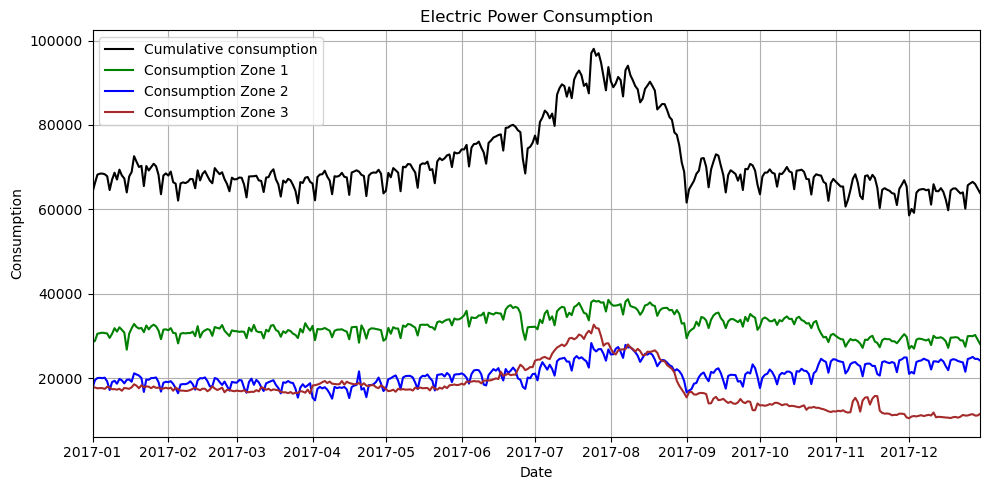

In [9]:
# Plot actual and fitted serie
plt.figure(figsize=(10, 5))                                      

plt.plot(raw_daily.index, raw_daily['Consumption'], label='Cumulative consumption', color='black')     
plt.plot(raw_daily.index, raw_daily['PowerConsumption_Zone1'], label='Consumption Zone 1', color='green')   
plt.plot(raw_daily.index, raw_daily['PowerConsumption_Zone2'], label='Consumption Zone 2', color='blue')   
plt.plot(raw_daily.index, raw_daily['PowerConsumption_Zone3'], label='Consumption Zone 3', color='brown')   

plt.title('Electric Power Consumption')                      
plt.xlabel('Date')                                        
plt.ylabel('Consumption')  
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-12-30'))
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [10]:
# Split the data
cutoff = pd.to_datetime("2017-12-01")

train = raw_daily[raw_daily.index < cutoff]
test = raw_daily[raw_daily.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (334, 9)
Test shape: (30, 9)

             Consumption  Temperature   Humidity  WindSpeed  \
2017-11-26  61038.224827    15.808681  63.248194   3.966958   
2017-11-27  64878.395589    13.051250  79.359167   0.579944   
2017-11-28  65853.076883    16.711528  70.992014   4.165403   
2017-11-29  66926.180006    16.910417  66.288403   3.392104   
2017-11-30  65452.570795    14.044583  76.022639   0.074806   

            GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
2017-11-26           125.298521     19.945160            28298.034188   
2017-11-27           121.506993     27.517021            29000.470086   
2017-11-28           119.178368     22.796514            29775.598291   
2017-11-29           107.111215     28.051174            30450.769231   
2017-11-30           119.248938     28.353924            29805.726496   

            PowerConsumption_Zone2  PowerConsumption_Zone3  
2017-11-26            21437.138430            11303.052209  
2017-11-27       

In [11]:
con_series = train['Consumption']

len(con_series)

334

In [12]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(con_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -1.7716, p-value = 0.3947
d = 1 | ADF Statistic = -4.1340, p-value = 0.0009

Non-seasonal differencing term (d): 1


In [13]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(con_series)

Detected Seasonal Period: S = 334


In [14]:
def detect_top_seasonal_periods(series, top_n=5):
    import numpy as np
    import pandas as pd

    # Remove mean to center the series
    series_detrended = series - np.mean(series)

    # Apply Fourier Transform
    fourier = np.fft.fft(series_detrended)
    frequencies = np.fft.fftfreq(len(series))

    # Only keep positive frequencies (exclude zero)
    positive_mask = frequencies > 0
    positive_freqs = frequencies[positive_mask]
    magnitudes = np.abs(fourier[positive_mask])

    # Get indices of top N magnitudes
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]

    # Prepare result
    top_periods = [(round(1 / positive_freqs[i], 2), magnitudes[i]) for i in top_indices]

    # Display results
    print("Top Seasonal Periods (in time units):")
    for i, (period, magnitude) in enumerate(top_periods, 1):
        print(f"{i}. Period = {period} (Frequency = {round(positive_freqs[top_indices[i-1]], 5)}), Magnitude = {round(magnitude, 2)}")


detect_top_seasonal_periods(con_series, top_n=10)

Top Seasonal Periods (in time units):
1. Period = 334.0 (Frequency = 0.00299), Magnitude = 1434159.69
2. Period = 167.0 (Frequency = 0.00599), Magnitude = 976440.61
3. Period = 111.33 (Frequency = 0.00898), Magnitude = 461998.59
4. Period = 83.5 (Frequency = 0.01198), Magnitude = 397436.02
5. Period = 66.8 (Frequency = 0.01497), Magnitude = 338098.6
6. Period = 6.96 (Frequency = 0.14371), Magnitude = 251045.08
7. Period = 30.36 (Frequency = 0.03293), Magnitude = 167493.24
8. Period = 2.34 (Frequency = 0.42814), Magnitude = 164720.65
9. Period = 55.67 (Frequency = 0.01796), Magnitude = 144869.84
10. Period = 20.88 (Frequency = 0.0479), Magnitude = 141864.72


In [15]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 13, 25, 67]:

    D = determine_seasonal_D(con_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 13: 0
Seasonal differencing term (D) for 25: 0
Seasonal differencing term (D) for 67: 0


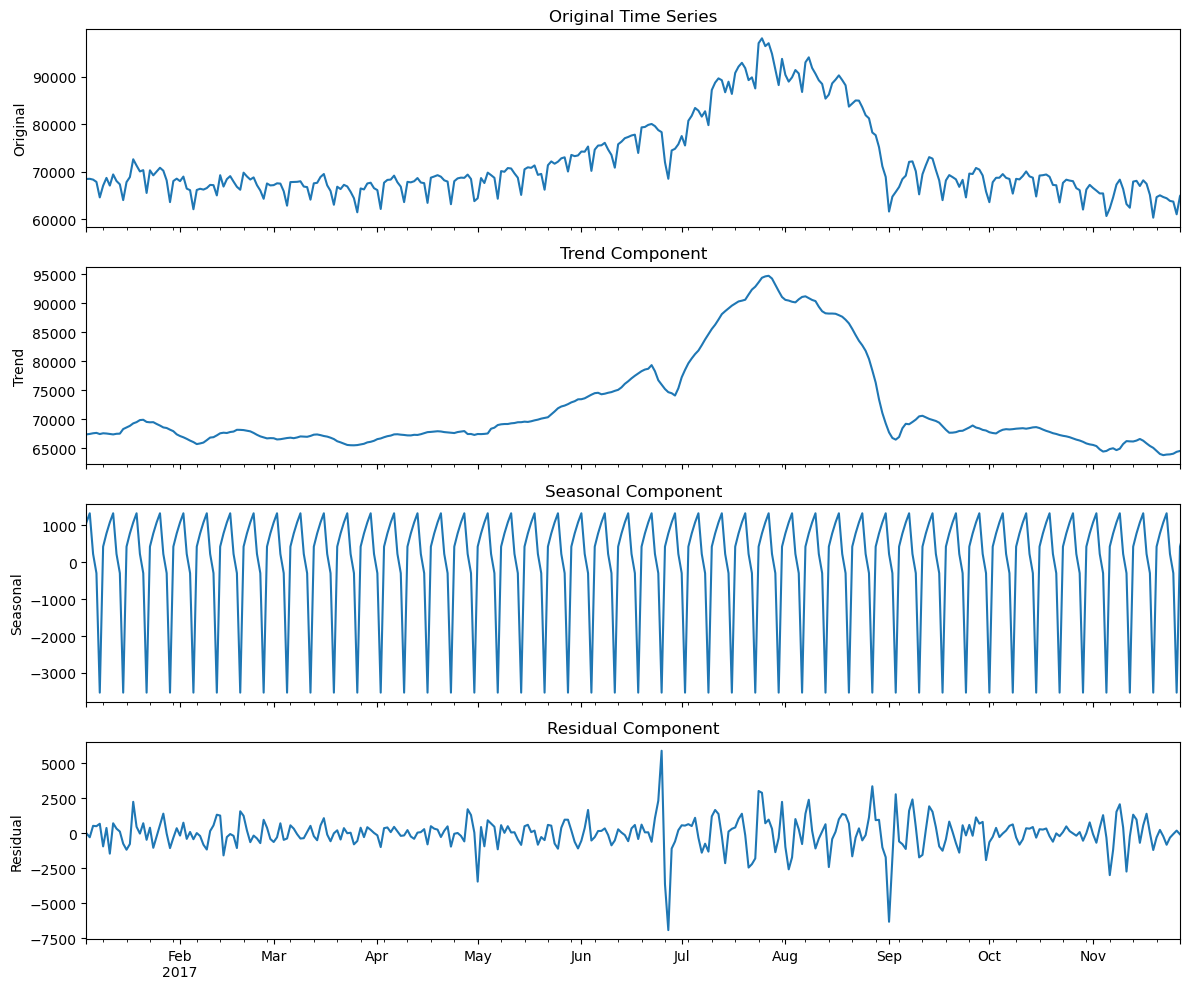

In [16]:
result = seasonal_decompose(con_series, model='aditive', period=7)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

# SARIMAX

In [17]:
def best_auto_arima(series, d=0, D=0, S=12):

    # Perform a full search over the same grid as your manual SARIMAX model
    auto_model = pm.auto_arima(
        series,                     # The time series data
        seasonal=True,              # Enable seasonal component
        m=S,                        # Seasonal period
        d=d,                        # Set differencing 
        D=D,                        # Set seasonal differencing
        start_p=0, max_p=3,         # p 
        start_q=0, max_q=3,         # q 
        start_P=0, max_P=3,         # P 
        start_Q=0, max_Q=3,         # Q 
        stepwise=False,             # Disable stepwise search (enable full grid search)
        trace=False,                # Print model search progress
        error_action='ignore',      # Ignore errors and continue
        suppress_warnings=True,     # Suppress convergence warnings
        information_criterion='aic' # Use AIC to choose the best model
    )

    # Print the best model found
    print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

best_auto_arima(con_series, d=1, D=0, S=7)

Best model: SARIMA(0, 1, 0)(1, 0, 1, 7)


In [18]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=con_series, d=1, D=0, S=7)

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,7)
Running model #15 using SARIMA(0,1,0)(3,0,3,7)
Running model #30 using SARIMA(0,1,1)(3,0,2,7)
Running model #45 using SARIMA(0,1,2)(3,0,1,7)
Running model #60 using SARIMA(0,1,3)(3,0,0,7)
Running model #75 using SARIMA(1,1,0)(2,0,3,7)
Running model #90 using SARIMA(1,1,1)(2,0,2,7)
Running model #105 using SARIMA(1,1,2)(2,0,1,7)
Running model #120 using SARIMA(1,1,3)(2,0,0,7)
Running model #135 using SARIMA(2,1,0)(1,0,3,7)
Running model #150 using SARIMA(2,1,1)(1,0,2,7)
Running model #165 using SARIMA(2,1,2)(1,0,1,7)
Running model #180 using SARIMA(2,1,3)(1,0,0,7)
Running model #195 using SARIMA(3,1,0)(0,0,3,7)
Running model #210 using SARIMA(3,1,1)(0,0,2,7)
Running model #225 using SARIMA(3,1,2)(0,0,1,7)
Running model #240 using SARIMA(3,1,3)(0,0,0,7)
Running model #255 using SARIMA(3,1,3)(3,0,3,7)

Best models by AIC:
   index non-seasonal order seasonal order          AIC
0     63          (0, 1, 3)      (3, 0,

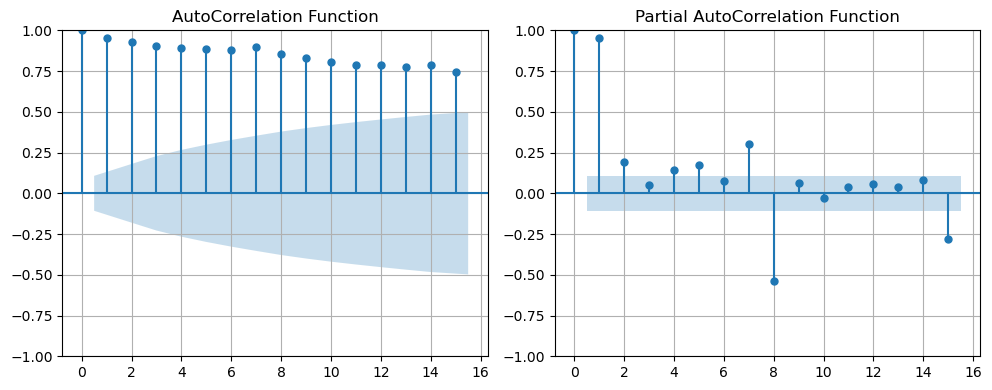

In [19]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(con_series, lagsn=15)

In [20]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_013 = SARIMAX(con_series,                     # Time series data
                    order=(0, 1, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(3, 0, 3, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_013 = model_013.fit()

# Display summary of the model
print(model_fit_013.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       Consumption   No. Observations:                  334
Model:             SARIMAX(0, 1, 3)x(3, 0, 3, 7)   Log Likelihood               -2699.418
Date:                           Wed, 21 May 2025   AIC                           5418.836
Time:                                   14:04:41   BIC                           5456.137
Sample:                               01-01-2017   HQIC                          5433.751
                                    - 11-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0440      0.035      1.251      0.211      -0.025       0.113
ma.L2         -0.1099      0.029     -3.804

In [21]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_013)

ma.L1 coefficient: 0.0440
ma.L1 95% CI: (-0.0249, 0.1129)
ma.L1 p-value: 0.2110
ma.L1 is statistically IRRELEVANT in the model.

ma.L3 coefficient: 0.0076
ma.L3 95% CI: (-0.0846, 0.0998)
ma.L3 p-value: 0.8720
ma.L3 is statistically IRRELEVANT in the model.

ar.S.L14 coefficient: -0.9112
ar.S.L14 95% CI: (-1.9225, 0.1001)
ar.S.L14 p-value: 0.0774
ar.S.L14 is statistically IRRELEVANT in the model.

ar.S.L21 coefficient: 0.2940
ar.S.L21 95% CI: (-0.0697, 0.6577)
ar.S.L21 p-value: 0.1132
ar.S.L21 is statistically IRRELEVANT in the model.

ma.S.L14 coefficient: 0.8382
ma.S.L14 95% CI: (-0.1253, 1.8017)
ma.S.L14 p-value: 0.0882
ma.S.L14 is statistically IRRELEVANT in the model.

ma.S.L21 coefficient: -0.2441
ma.S.L21 95% CI: (-0.5769, 0.0888)
ma.S.L21 p-value: 0.1507
ma.S.L21 is statistically IRRELEVANT in the model.



In [22]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_012 = SARIMAX(con_series,                     # Time series data
                    order=(0, 1, 2),                # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 0, 2, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_012 = model_012.fit()

# Display summary of the model
print(model_fit_012.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       Consumption   No. Observations:                  334
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -2799.584
Date:                           Wed, 21 May 2025   AIC                           5613.168
Time:                                   14:04:42   BIC                           5639.458
Sample:                               01-01-2017   HQIC                          5623.671
                                    - 11-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0024      0.037     -0.064      0.949      -0.075       0.070
ma.L2         -0.1328      0.039     -3.442

In [23]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_012)

ma.L1 coefficient: -0.0024
ma.L1 95% CI: (-0.0749, 0.0701)
ma.L1 p-value: 0.9490
ma.L1 is statistically IRRELEVANT in the model.

ma.S.L7 coefficient: 0.0504
ma.S.L7 95% CI: (-0.0188, 0.1195)
ma.S.L7 p-value: 0.1534
ma.S.L7 is statistically IRRELEVANT in the model.



In [24]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_011 = SARIMAX(con_series,                     # Time series data
                    order=(0, 1, 1),                # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 0, 1, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_011 = model_011.fit()

# Display summary of the model
print(model_fit_011.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       Consumption   No. Observations:                  334
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -2835.598
Date:                           Wed, 21 May 2025   AIC                           5681.196
Time:                                   14:04:42   BIC                           5700.022
Sample:                               01-01-2017   HQIC                          5688.714
                                    - 11-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0381      0.036     -1.052      0.293      -0.109       0.033
ar.S.L7        0.7482      0.058     12.898

In [25]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_011)

ma.L1 coefficient: -0.0381
ma.L1 95% CI: (-0.1092, 0.0329)
ma.L1 p-value: 0.2930
ma.L1 is statistically IRRELEVANT in the model.



In [26]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_010 = SARIMAX(con_series,                     # Time series data
                    order=(0, 1, 0),                # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 0, 1, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_010 = model_010.fit()

# Display summary of the model
print(model_fit_010.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Consumption   No. Observations:                  334
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -2835.785
Date:                             Wed, 21 May 2025   AIC                           5679.570
Time:                                     14:04:42   BIC                           5694.631
Sample:                                 01-01-2017   HQIC                          5685.585
                                      - 11-30-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.7522      0.058     13.043      0.000       0.639       0.865
ar.S.L14       0.1455      

In [27]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_010)

All variables are statistically relevant.


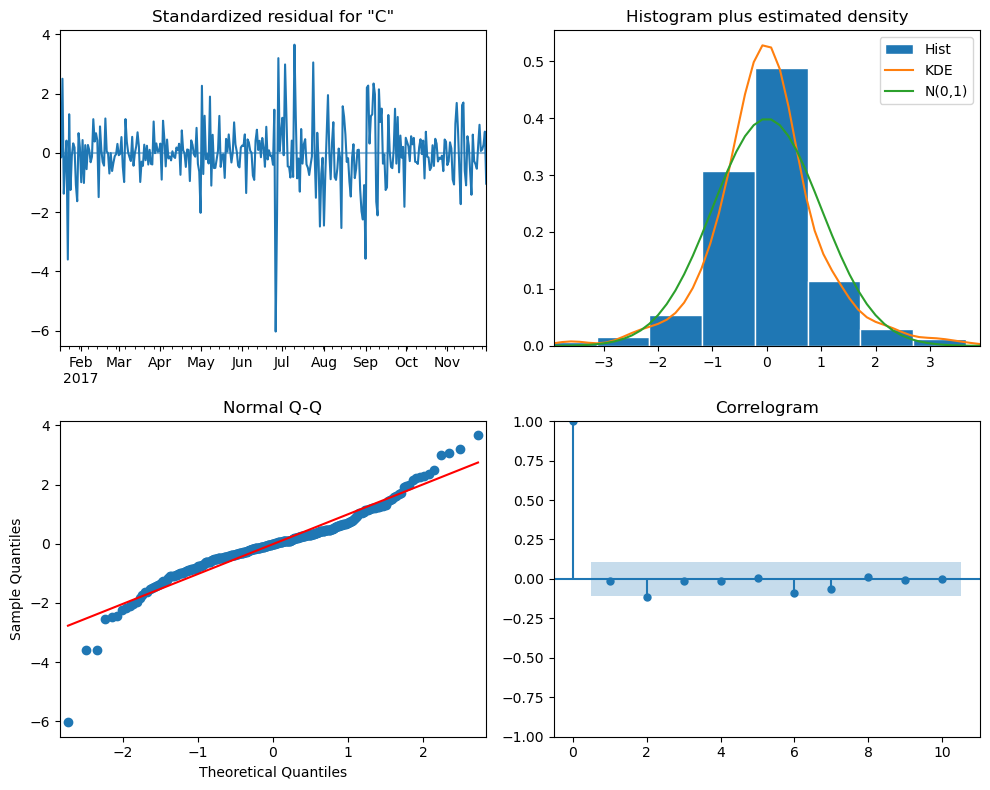

In [28]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_010.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [29]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_010.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.062650,0.802355
2,0.067637,0.966747
3,0.079605,0.994167
4,0.087198,0.999077
5,0.099150,0.999841
6,0.365232,0.999114
7,18.963935,0.008301
8,18.976082,0.014988
9,19.058434,0.024701
10,19.659578,0.032642


In [30]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.2905
Conclusion: Evidence of positive autocorrelation.


In [31]:
# Forecast the next Time points
forecast_S = model_fit_010.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()        

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                 # Forecast mean

test['Error S'] = test['Forecast S'] - test['Consumption']

test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values       # Lower bound
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values       # Upper bound

# Show the updated test DataFrame
test.head()

,Consumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
2017-12-01,58574.151543,17.141875,68.535556,0.081743,113.943521,36.527521,26995.901986,21047.637312,10530.612245,64757.871366,6183.719823,61344.374925,68171.367806
2017-12-02,60104.345342,16.131667,63.794653,0.082875,83.212083,40.531736,27669.370511,21498.440217,10936.534614,63682.931402,3578.586061,58855.518441,68510.344364
2017-12-03,59192.378189,14.080833,70.362639,1.247875,77.156937,37.144583,27016.603295,21116.191061,11059.583833,60933.593450,1741.215261,55021.244183,66845.942717
2017-12-04,63970.419074,13.886319,71.671389,2.049319,95.568014,39.307833,29151.626531,23862.329958,10956.462585,64374.951329,404.532255,57547.958447,71201.944210
2017-12-05,64623.070345,12.006181,70.056042,0.716500,121.769931,37.620653,29394.888044,24108.494426,11119.687875,64979.319171,356.248826,57346.509089,72612.129253


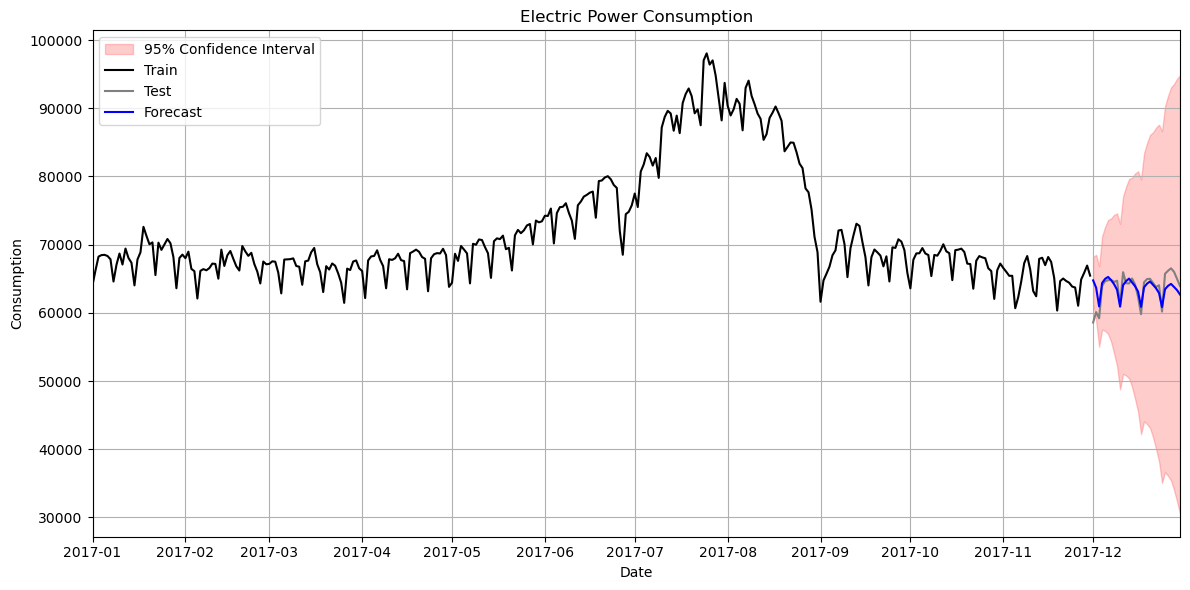

In [32]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Consumption'], label='Train', color='black')   # Train
plt.plot(test.index, test['Consumption'], label='Test', color='gray')       # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Electric Power Consumption')                      
plt.xlabel('Date')                                        
plt.ylabel('Consumption')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-12-30'))
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

# SARIMAX Model with Exogenous Variables

In [33]:
# Drop the three original power consumption columns
train = train.drop(columns=['PowerConsumption_Zone1', 
                            'PowerConsumption_Zone2', 
                            'PowerConsumption_Zone3']) 

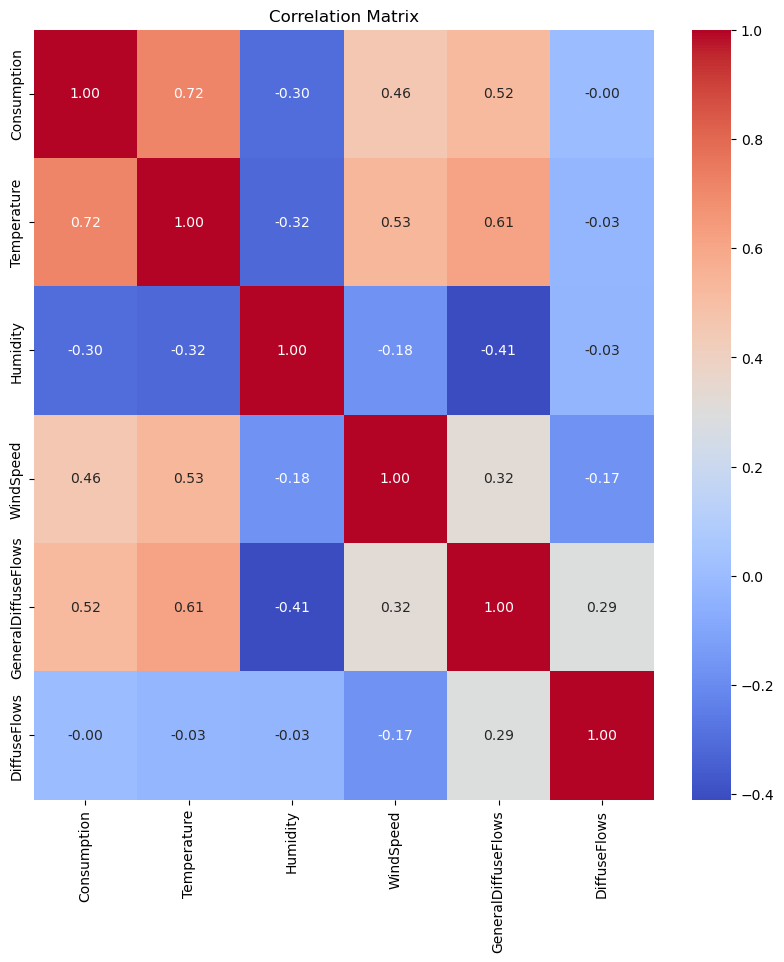

In [34]:
# Compute correlation matrix
c_matrix = train.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [35]:
# Identify columns where the first row value is >= 0.7 or <= -0.7
selected_columns = c_matrix.columns[np.logical_or(c_matrix.iloc[0] >= 0.70, 
                                                  c_matrix.iloc[0] <= -0.70)]

# Convert to list and remove target series
filtered_columns = [col for col in selected_columns if col != 'Consumption']

# Show the result
print(filtered_columns)

['Temperature']


In [36]:
# Create candidates dataframe
candidates = train[['Temperature', 'GeneralDiffuseFlows']]

# Compute correlation matrix
corr_candidates = candidates.corr()

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(corr_candidates.values, i), 2) for i in range(len(corr_candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = corr_candidates.corr().round(2)
print(f'Correlation:\n{corr}')

                      VIF         Interpretation
Feature                                         
Temperature          4.82  Not Multicollinearity
GeneralDiffuseFlows  4.82  Not Multicollinearity

Correlation:
                     Temperature  GeneralDiffuseFlows
Temperature                  1.0                 -1.0
GeneralDiffuseFlows         -1.0                  1.0


In [38]:
# Multiple column selection
exog_data = train[['Temperature']]  

# Target variable selection
endog_data = train['Consumption']        

In [39]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(0, 1, 0),               
                  seasonal_order=(2, 0, 1, 7),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Consumption   No. Observations:                  334
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -2836.655
Date:                             Wed, 21 May 2025   AIC                           5683.311
Time:                                     14:04:43   BIC                           5702.137
Sample:                                 01-01-2017   HQIC                          5690.829
                                      - 11-30-2017                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    44.1914     64.813      0.682      0.495     -82.839     171.222
ar.S.L7         0.7652  

In [40]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

Temperature coefficient: 44.1914
Temperature 95% CI: (-82.8394, 171.2223)
Temperature p-value: 0.4953
Temperature is statistically IRRELEVANT in the model.



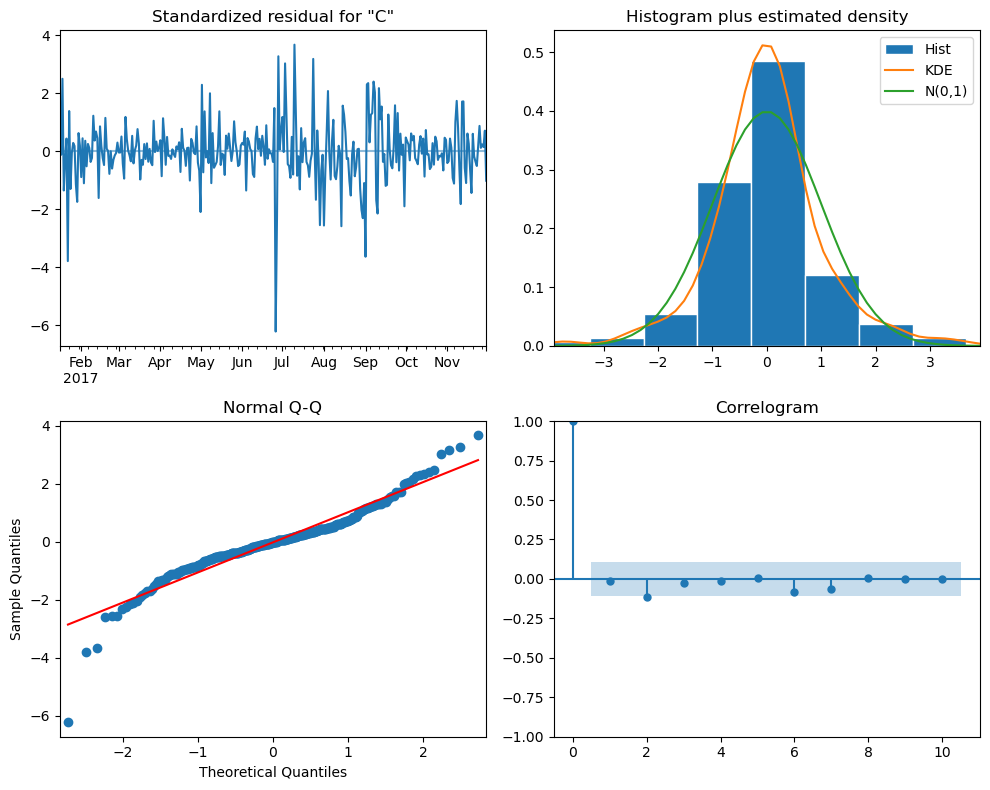

In [41]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [42]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.050334,0.822483
2,0.055484,0.972639
3,0.067680,0.995411
4,0.078432,0.999251
5,0.090196,0.999874
6,0.339977,0.999279
7,19.506743,0.006740
8,19.514911,0.012336
9,19.603434,0.020524
10,20.190820,0.027499


In [43]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.2984
Conclusion: Evidence of positive autocorrelation.


In [44]:
# Must match the structure of training exog
exog_test_M = test[['Temperature']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['Consumption']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,Consumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
2017-12-01,58574.151543,17.141875,68.535556,0.081743,113.943521,36.527521,26995.901986,21047.637312,10530.612245,64757.871366,6183.719823,61344.374925,68171.367806,64855.056343,6280.904800,61533.352248,68176.760437
2017-12-02,60104.345342,16.131667,63.794653,0.082875,83.212083,40.531736,27669.370511,21498.440217,10936.534614,63682.931402,3578.586061,58855.518441,68510.344364,63665.779956,3561.434614,58968.180975,68363.378936
2017-12-03,59192.378189,14.080833,70.362639,1.247875,77.156937,37.144583,27016.603295,21116.191061,11059.583833,60933.593450,1741.215261,55021.244183,66845.942717,60853.923301,1661.545112,55100.563041,66607.283560
2017-12-04,63970.419074,13.886319,71.671389,2.049319,95.568014,39.307833,29151.626531,23862.329958,10956.462585,64374.951329,404.532255,57547.958447,71201.944210,64299.478941,329.059867,57656.070752,70942.887130
2017-12-05,64623.070345,12.006181,70.056042,0.716500,121.769931,37.620653,29394.888044,24108.494426,11119.687875,64979.319171,356.248826,57346.509089,72612.129253,64819.449791,196.379446,57391.893634,72247.005948


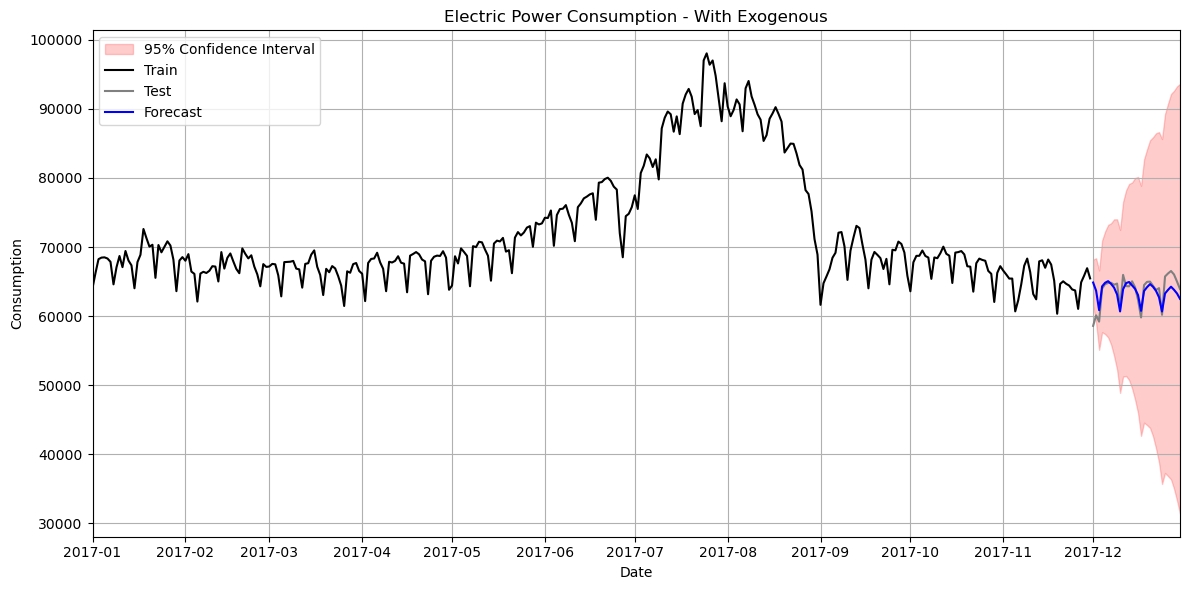

In [45]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Consumption'], label='Train', color='black')   # Train
plt.plot(test.index, test['Consumption'], label='Test', color='gray')       # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Electric Power Consumption - With Exogenous')                      
plt.xlabel('Date')                                        
plt.ylabel('Consumption')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-12-30'))
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['Consumption'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['Consumption'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['Consumption'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test['Consumption'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['Consumption'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['Consumption'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

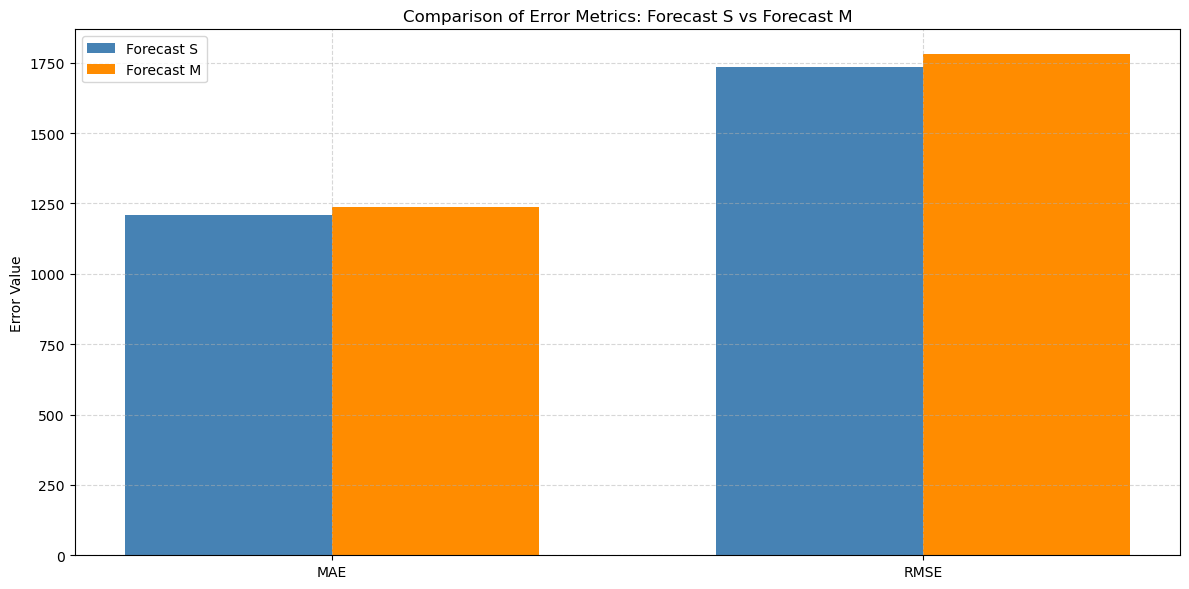

In [47]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [48]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,1207.93,1236.20
RMSE,1736.33,1779.78


In [49]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
mape_s = mean_absolute_percentage_error(test['Consumption'], test['Forecast S']) * 100
mape_m = mean_absolute_percentage_error(test['Consumption'], test['Forecast M']) * 100

# Create DataFrame for Error Analysis
comparison_mape = pd.DataFrame([mape_s, mape_m], index=['MAPE S', 'MAPE M']).T.round(2) 
comparison_mape

,MAPE S,MAPE M
0,1.92,1.96


Despite the correlation between `Temperature` and `Consumption` be 0.72, the mathematical model shows for `Temperature`:

    Temperature coefficient: 44.1914
    Temperature 95% CI: (-82.8394, 171.2223)
    Temperature p-value: 0.4953
    Temperature is statistically IRRELEVANT in the model.

*Add Temperature does not improve the model.*

1. A correlation of 0.72 only means they move together, not that temperature explains future consumption in a predictive way.

2. If `Temperature` follows a similar seasonal pattern, the seasonal AR/MA terms already absorb that signal. Result: `Temperature` contributes redundant information, adding complexity but no gain.

3. p-value = 0.495 ⇒ Not statistically significant. That means once the SARIMAX model accounts for lag and seasonality, `Temperature` doesn’t explain much extra variance.

4. Adding `Temperature` when it’s strongly seasonal can inflate standard errors. SARIMAX uses differencing (d=1) — so the model focuses on changes, not levels (correlation in levels is lost after differencing). If `Temperature` and `Consumption` are cointegrated, SARIMAX won't capture that directly.

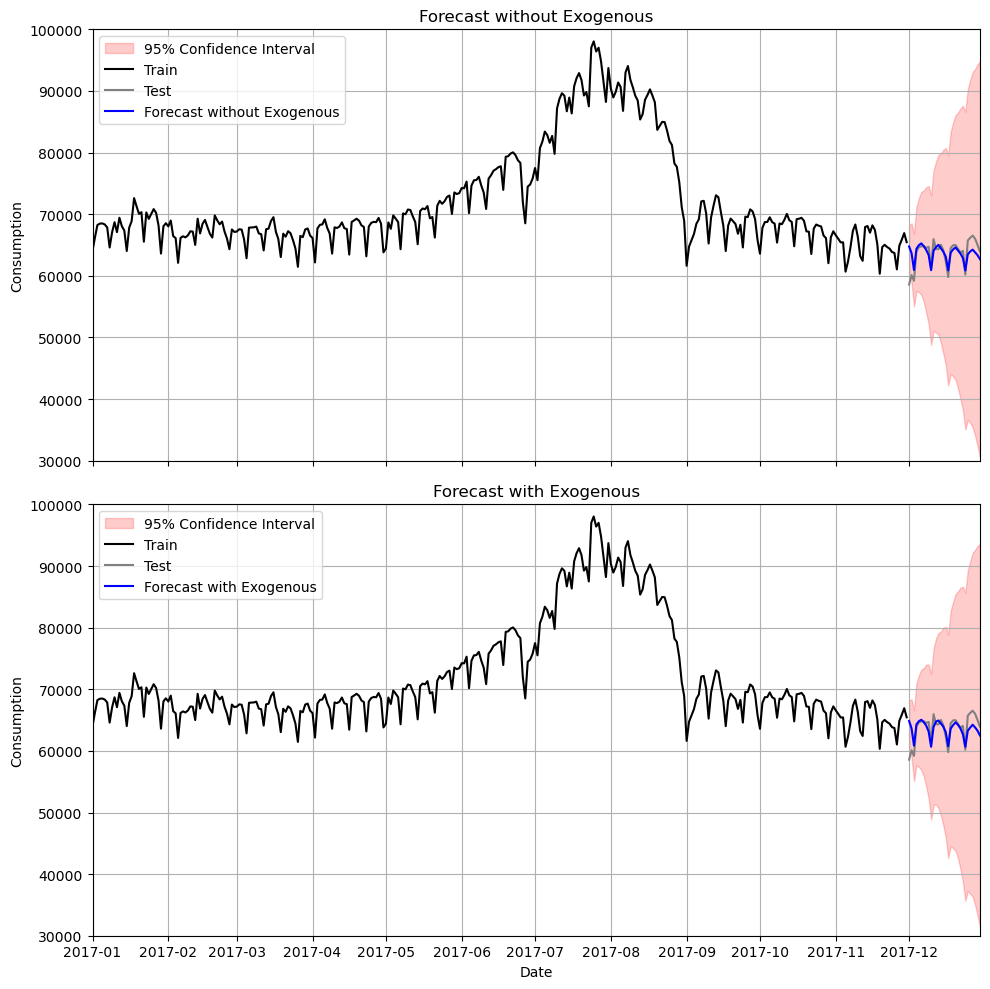

In [50]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['Consumption'], label='Train', color='black')
axes[0].plot(test.index, test['Consumption'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Consumption')
axes[0].legend(loc=2)
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-12-30'))
axes[0].set_ylim(30000, 100000)

# --- Second Forecast (Forecast M) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['Consumption'], label='Train', color='black')
axes[1].plot(test.index, test['Consumption'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Consumption')
axes[1].legend(loc=2)
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-12-30'))
axes[1].set_ylim(30000, 100000)

# Final layout
plt.tight_layout()
plt.show()

End.